In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve
from matplotlib import rcParams
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc,roc_auc_score
import umap
from sklearn.inspection import permutation_importance
import os
import sklearn.cluster as cluster
import warnings
warnings.filterwarnings('ignore')
os.chdir('E:/final_dataset/')

In [2]:
data = pd.read_csv('CN_patchseq_Ephysi_metaInformation_integrated_20230207.csv')

In [3]:
data =data[data['recording'].isin(['good','ok'])]
data =data[data['Expert_label'].isin(['L-stellate','D-stellate','Cartwheel','Vertical','SSC'])]
data =data[~data['Penk_tdTomato'].isin(['YES'])]
data = data.fillna(0)

In [4]:
labels = ['L-stellate','D-stellate','Cartwheel','Vertical','SSC']
labels  = sorted(labels)

In [5]:
adata = data[[
'Tau (ms)', 
'SagRatio', 
'Rebound (mV)', 
'RM (Mohm)', 
'RMP (mV)',      
'RheoBase (pA)', 
'Spike Delay (ms)', 
'Threshold (mV)', 
'Amplitude (mV)',
'AHP (mV)', 
'Depolarization Time (ms)', 
'Repolarization Time (ms)',
'Half Width (ms)', 
'Max Spike Number', 
'AP Number @ 2xRheabase',
'Initial Adaptation', 'Last Adaptation', 'AP2_Diff', 'AP3_Diff',#'AP_End_Diff', 
#'Rebound_abs (mV)', 
#'Rebound_spikes',
'Spike_Delay @ 2xRheobase',
"Expert_label"]].copy()

In [6]:
X = adata.drop(['Expert_label'], axis=1)
para = list(X.columns)
#x = x.values
X = StandardScaler().fit_transform(X)
y = adata['Expert_label']
print(f'x shape: {X.shape} | y shape: {y.shape} ')

x shape: (172, 20) | y shape: (172,) 


In [7]:
clf = RandomForestClassifier(n_estimators=100,random_state=0,bootstrap =True, n_jobs = 10)

In [8]:
random_state_n = []
n = 0
for i in range(0,20000,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if accuracy_score(y_test, y_pred) > 0.85:
        n  = n + 1
        random_state_n.append(i)
        if n == 100:
            break

In [10]:
cm = 0
train_score = 0
test_score = 0
fpr1 = pd.DataFrame()
tpr1 = pd.DataFrame()
fpr2 = pd.DataFrame()
tpr2 = pd.DataFrame()
fpr3 = pd.DataFrame()
tpr3 = pd.DataFrame()
fpr4 = pd.DataFrame()
tpr4 = pd.DataFrame()
fpr5 = pd.DataFrame()
tpr5 = pd.DataFrame()
importances = pd.DataFrame(index = para,columns = ['importances'])
importances['importances'] = 0.0
k = 0
for i in random_state_n:
    #print(k+1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    matrix = confusion_matrix(y_test, y_pred)
    cm = cm+matrix
    ###Learning Curve
    train_sizes =  np.arange(0.1,1,0.025)
    sizes, training_scores, testing_scores = learning_curve(clf, X_train, y_train,
                                                            scoring='accuracy', train_sizes=train_sizes)
    mean_training = np.mean(training_scores, axis=1)
    train_score = train_score+mean_training
    Standard_Deviation_training = np.std(training_scores, axis=1)
    mean_testing = np.mean(testing_scores, axis=1)
    test_score = test_score + mean_testing
    Standard_Deviation_testing = np.std(testing_scores, axis=1)
    ###Freature importance
    importance = pd.DataFrame(clf.feature_importances_,index = para,columns = ['importances'])
    importances  = importances + importance
    ###ROC curve
    pred_prob = clf.predict_proba(X_test)
    fpr = {}
    tpr = {}
    thresh ={}
    n_class =labels
    for j in range(5):    
        fpr[j], tpr[j], thresh[j] = roc_curve(y_test, pred_prob[:,j], pos_label=n_class[j])
    fpr1[k] = pd.DataFrame(fpr[0])
    tpr1[k] = pd.DataFrame(tpr[0])
    fpr2[k] = pd.DataFrame(fpr[1])
    tpr2[k] = pd.DataFrame(tpr[1])
    fpr3[k] = pd.DataFrame(fpr[2])
    tpr3[k] = pd.DataFrame(tpr[2])
    fpr4[k] = pd.DataFrame(fpr[3])
    tpr4[k] = pd.DataFrame(tpr[3])
    fpr5[k] = pd.DataFrame(fpr[4])
    tpr5[k] = pd.DataFrame(tpr[4])
    k=k+1

In [11]:
true_n = 0
total_n = 0
for i in range(0,5,1):
    print(labels[i],cm[i,i],'/',sum(cm[:,i]), str('%.2f'%(cm[i,i]/sum(cm[:,i])*100.0))+'%')
    true_n = true_n + cm[i,i]
    total_n = total_n + sum(cm[:,i])   
    acur_rate = true_n/total_n*100.0

print(str('%.2f'%(acur_rate))+'%')

Cartwheel 1181 / 1224 96.49%
D-stellate 1007 / 1104 91.21%
L-stellate 2290 / 2746 83.39%
SSC 762 / 930 81.94%
Vertical 2227 / 2596 85.79%
86.83%


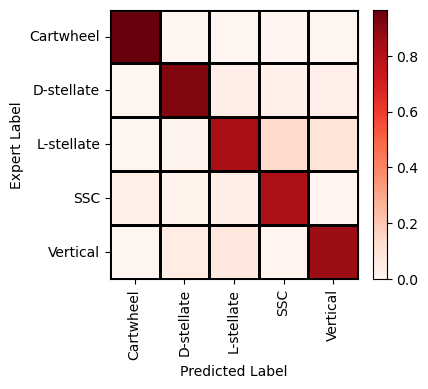

In [11]:
cm = cm.astype(np.float32)
for i in range(0,5,1):
    cm[:,i] = cm[:,i]/sum(cm[:,i])
rcParams['figure.figsize'] = 4, 3.5
ax = sns.heatmap(cm, cmap='Reds',cbar=True,
                 linewidths=1, linecolor='black'#,annot = True, annot_kws = {'size':14},fmt='0.3f'
                )
sns.despine(top = False, right = False, left = False,bottom = False)  
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_yticklabels(ax.get_yticklabels(),rotation = 0)

plt.rc('axes', titlesize=16)     
plt.rc('axes', labelsize=16)
plt.rc('font', size=16) 
plt.rc('figure', titlesize=16)
plt.rc('legend', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('Expert Label')
plt.savefig('InN_E_cluster_ML_Matrix_WO.pdf',dpi = 300)

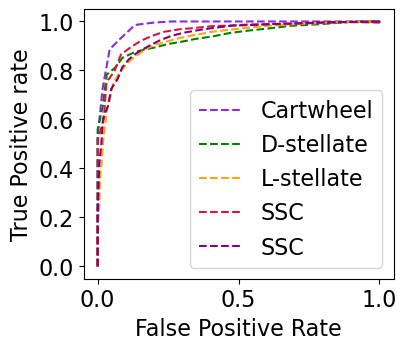

In [12]:
plt.plot(fpr1.mean(axis=1)/max(fpr1.mean(axis=1)), 
         tpr1.mean(axis=1)/max(tpr1.mean(axis=1)),
         linestyle='--',color='blueviolet', label=n_class[0])
plt.plot(fpr2.mean(axis=1)/max(fpr2.mean(axis=1)), 
         tpr2.mean(axis=1)/max(tpr2.mean(axis=1)), 
         linestyle='--',color='green', label=n_class[1])
plt.plot(fpr3.mean(axis=1)/max(fpr3.mean(axis=1)), 
         tpr3.mean(axis=1)/max(tpr3.mean(axis=1)), 
         linestyle='--',color='orange', label=n_class[2])
plt.plot(fpr4.mean(axis=1)/max(fpr4.mean(axis=1)), 
         tpr4.mean(axis=1)/max(tpr4.mean(axis=1)), 
         linestyle='--',color='crimson', label=n_class[3])
plt.plot(fpr5.mean(axis=1)/max(fpr5.mean(axis=1)), 
         tpr5.mean(axis=1)/max(tpr5.mean(axis=1)), 
         linestyle='--',color='purple', label=n_class[3])

rcParams['figure.figsize'] = 4, 4
#plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.show()
plt.savefig('InN_E_ROC_WO.pdf',dpi = 300)

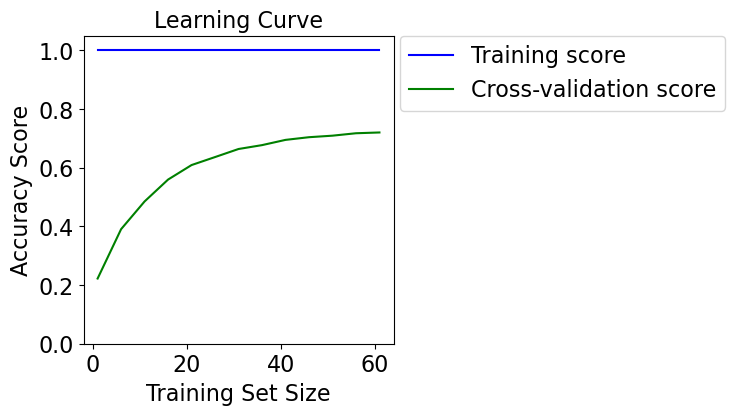

In [13]:
rcParams['figure.figsize'] = 4, 4     
# dotted blue line is for training scores and green line is for cross-validation score
plt.plot(sizes, train_score/100, color="b",  label="Training score")
plt.plot(sizes, test_score/100, color="g", label="Cross-validation score")
plt.ylim(0.0, 1.05)
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,)
plt.tight_layout()
plt.savefig('InN_E_learning_curve_WO.pdf',dpi = 300)

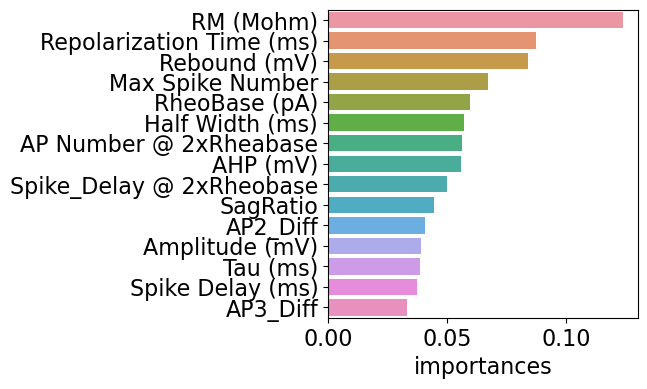

In [14]:
importances = importances.sort_values(by=['importances'],ascending=False)
rcParams['figure.figsize'] = 4, 4
sns.barplot(x= importances['importances'].iloc[0:15]/100, y = list(importances.index)[0:15])
plt.savefig('InN_E_importance_WOs.pdf',dpi = 300)

In [15]:
selected_var = importances.iloc[0:15]
var_name = list(selected_var.index)
adata = data[var_name].values
scaled_adata = StandardScaler().fit_transform(adata)
reducer = umap.UMAP(random_state =1,min_dist = 0.6,n_neighbors=15)
scaled_adata = pd.DataFrame(scaled_adata,columns= var_name)
for par in var_name:
    scaled_adata[par] = scaled_adata[par]*importances.loc[par]['importances']
scaled_adata = scaled_adata.values
embedding = reducer.fit_transform(scaled_adata)

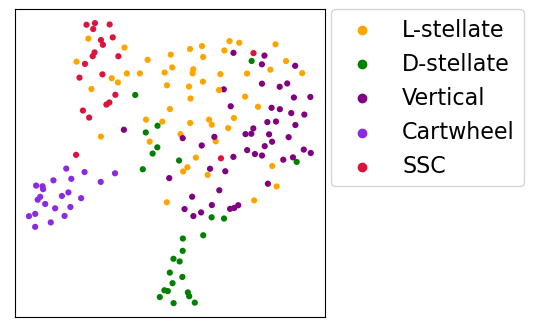

In [16]:
rcParams['figure.figsize'] = 4, 4
palette = {'Cartwheel':'blueviolet', 
           'D-stellate': 'green',
           'L-stellate': 'orange',
           'SSC': 'crimson',
           'Vertical': 'purple'
          }
sns.scatterplot(x=embedding[:, 0], y= embedding[:, 1],
                hue = y, s = 20,
                palette = palette,
                edgecolor="none",)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,)
plt.xticks([])
plt.yticks([])
plt.savefig('InN_E_cluster_true_label_WO.pdf',dpi = 300)

([], [])

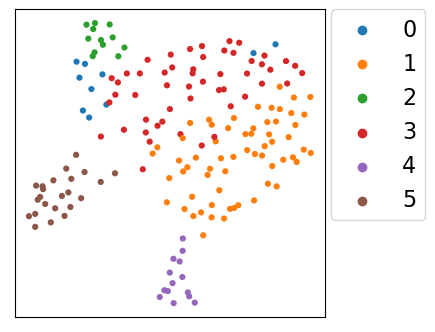

In [17]:
kmeans_labels = cluster.MiniBatchKMeans(n_clusters=6,random_state=2).fit_predict(scaled_adata)
rcParams['figure.figsize'] = 4, 4
# palette = {'Bushy': 'deepskyblue', 
#            'Octopus': 'violet',
#            'Fusiform': 'brown',
#            'T-stellate': 'coral'
#           }
palette = 'tab10'
sns.scatterplot(x=embedding[:, 0], y= embedding[:, 1],
                hue = kmeans_labels, s = 20,
                palette = palette,
                edgecolor="none",)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,)
plt.xticks([])
plt.yticks([])

Cartwheel 22 / 23 95.65%
D-stellate 14 / 14 100.00%
L-stellate 33 / 51 64.71%
SSC 17 / 22 77.27%
Vertical 39 / 62 62.90%
72.67%


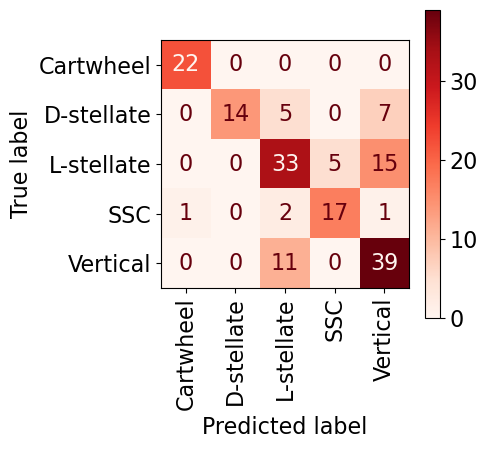

In [18]:
pred_labs = kmeans_labels.astype('object')
x_true = data.Expert_label
df = pd.DataFrame()
df['Expert_label'] =  x_true
df['pred'] = kmeans_labels
for i in range(0,kmeans_labels.max()+1,1):
    pred_labs[pred_labs == i] = df[df['pred'] == i].groupby(by = ['Expert_label']).count()['pred'].idxmax()

y_pred = pred_labs
cm = confusion_matrix(x_true, y_pred,#normalize = 'pred'
                     )

ax = ConfusionMatrixDisplay(cm, display_labels=labels)
ax.plot(cmap = 'Reds',xticks_rotation='vertical', include_values =True)

true_n = 0
total_n = 0
for i in range(0,5,1):
    print(labels[i],cm[i,i],'/',sum(cm[:,i]), str('%.2f'%(cm[i,i]/sum(cm[:,i])*100.0))+'%')
    true_n = true_n + cm[i,i]
    total_n = total_n + sum(cm[:,i])   

    acur_rate = true_n/total_n*100.0

print(str('%.2f'%(acur_rate))+'%')

Text(0, 0.5, 'Expert Label')

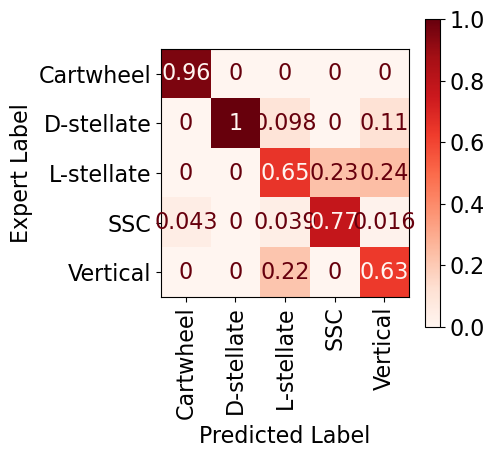

In [19]:
cm = cm.astype(np.float32)
for i in range(0,5,1):
    cm[:,i] = cm[:,i]/sum(cm[:,i])
x_true = data.Expert_label
y_pred = pred_labs
cm = confusion_matrix(x_true, y_pred,
                    normalize = 'pred'
                     )
labels  = sorted(labels)
ax = ConfusionMatrixDisplay(cm, display_labels=labels)
ax.plot(cmap = 'Reds',xticks_rotation='vertical', include_values =True)
#plt.grid(True)
plt.rc('axes', titlesize=16)     
plt.rc('axes', labelsize=16)
plt.rc('font', size=16) 
plt.rc('figure', titlesize=16)
plt.rc('legend', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('Expert Label')


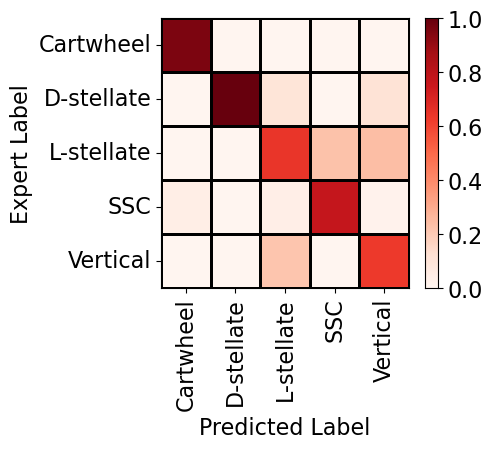

In [20]:
cm = cm.astype(np.float32)
for i in range(0,4,1):
    cm[:,i] = cm[:,i]/sum(cm[:,i])
rcParams['figure.figsize'] = 4, 3.5
ax = sns.heatmap(cm, cmap='Reds',cbar=True,
                 linewidths=1, linecolor='black'#,annot = True, annot_kws = {'size':14},fmt='0.3f'
                )
sns.despine(top = False, right = False, left = False,bottom = False)  
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_yticklabels(ax.get_yticklabels(),rotation = 0)

plt.rc('axes', titlesize=16)     
plt.rc('axes', labelsize=16)
plt.rc('font', size=16) 
plt.rc('figure', titlesize=16)
plt.rc('legend', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('Expert Label')
plt.savefig('InN_E_cluster_Matrix_WO.pdf',dpi = 300)

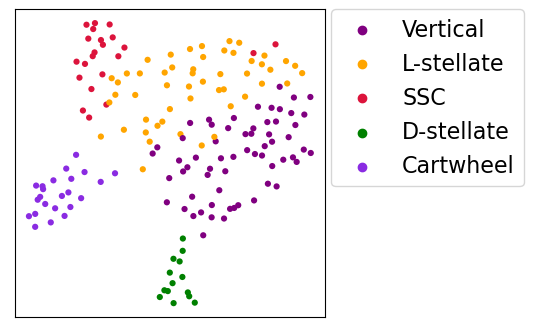

In [21]:
rcParams['figure.figsize'] = 4, 4
palette = {'Cartwheel':'blueviolet', 
           'D-stellate': 'green',
           'L-stellate': 'orange',
           'SSC': 'crimson',
           'Vertical': 'purple'
          }
sns.scatterplot(x=embedding[:, 0], y= embedding[:, 1],
                hue = pred_labs, s = 20,
                palette = palette,
                edgecolor="none",)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,)
plt.xticks([])
plt.yticks([])
plt.savefig('InN_E_cluster_pred_label_WO.pdf',dpi = 300)